# **Practico Mentoria - Introduccion al Aprendizaje Automatico**

Se propone la elaboración de un informe o presentación, en formato estatico:
* PDF
* Markdowns
* Google Docs

Que responda a las cuestiones solicitadas en cada seccion de esta **Jupyter Notebook**.

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase.  
Por lo cual debe estar redactado de forma consisa y comprensible.

In [1]:
!pip install scikit-plot

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

import scikitplot as skplt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline


sns.set_context(context='talk', font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
filename = "https://raw.githubusercontent.com/diplodatos2020/Introduccion_Mentoria/master/dataset_inf_telec_20200501T130000_20200727T010000_v1.csv"

In [4]:
df = pd.read_csv(
    filename,
    dtype={
        'ID_EQUIPO': int,
        'PUNTO_MEDICION': str,
        'CAPACIDAD_MAXIMA_GBS': float,
        'PASO': int,
        'LATENCIA_MS': float,
        'PORCENTAJE_PACK_LOSS': float,
        'INBOUND_BITS': np.float64,
        'OUTBOUND_BITS': np.float64,
        'MEDIDA': str,
    },
    parse_dates=[
        'FECHA_INICIO_MEDICION',
        'FECHA_HORA',
        'FECHA_FIN_MEDICION',
    ],
    na_values=['NaN']
)

In [5]:
df.shape

(61548, 12)

In [6]:
df.sample(5)

,ID_EQUIPO,PUNTO_MEDICION,CAPACIDAD_MAXIMA_GBS,FECHA_INICIO_MEDICION,FECHA_HORA,FECHA_FIN_MEDICION,PASO,LATENCIA_MS,PORCENTAJE_PACK_LOSS,INBOUND_BITS,OUTBOUND_BITS,MEDIDA
26087,4,NOC - SW Clientes 2,1.0,2020-05-28 15:00:00.000,2020-06-01 03:00:00,2020-06-04 15:00:00.000,1800,1.482113,0.297304,6.539841e+06,4.756020e+07,MB
45229,24,EDC - ET Oeste,1.0,2020-06-22 00:59:59.995,2020-06-27 05:00:00,2020-07-27 00:59:59.995,7200,2.634173,0.000000,2.252613e+06,7.183234e+06,MB
28087,31,RDB - GZU,10.0,2020-05-28 15:00:00.000,2020-05-31 19:00:00,2020-06-04 15:00:00.000,1800,1.376101,0.000000,2.452327e+08,3.128218e+09,GB
54457,4,NOC - Switch Servers,1.0,2020-06-22 00:59:59.995,2020-06-26 05:00:00,2020-07-27 00:59:59.995,7200,2.637318,0.000000,1.393799e+06,2.426059e+05,MB
31701,23,Yocsina - Mogote,10.0,2020-05-28 15:00:00.000,2020-05-30 02:00:00,2020-06-04 15:00:00.000,1800,2.085401,0.059486,2.528049e+08,3.884200e+08,GB


In [7]:
print(df.FECHA_HORA.min())

print(df.FECHA_HORA.max())

2020-05-01 03:00:00
2020-07-27 01:00:00


#### Reetiquetar las columnas del dataset para seguir con la misma nomenclatura que el ejericio anterior

In [8]:
df.dtypes

ID_EQUIPO                         int64
PUNTO_MEDICION                   object
CAPACIDAD_MAXIMA_GBS            float64
FECHA_INICIO_MEDICION    datetime64[ns]
FECHA_HORA               datetime64[ns]
FECHA_FIN_MEDICION       datetime64[ns]
PASO                              int64
LATENCIA_MS                     float64
PORCENTAJE_PACK_LOSS            float64
INBOUND_BITS                    float64
OUTBOUND_BITS                   float64
MEDIDA                           object
dtype: object

In [9]:
# nombre a minusculas
df.columns = df.columns.str.lower()
# eliminado de espacios de borde 
df.columns = df.columns.str.strip()
# reemplazo de espacios por "_"
df.columns = df.columns.str.replace(' ', '_')
# elimnar caracter % 
df.columns = df.columns.str.replace('%_', 'porcentaje_')
# eliminar strings que tengan el patron [ y ] usando exp regulares
df.columns = df.columns.str.replace('(\[|\])', '', regex=True)
df.sample(5)

,id_equipo,punto_medicion,capacidad_maxima_gbs,fecha_inicio_medicion,fecha_hora,fecha_fin_medicion,paso,latencia_ms,porcentaje_pack_loss,inbound_bits,outbound_bits,medida
50776,62,NOC - 6720HI to RPrivado,1.000000,2020-06-22 00:59:59.995,2020-07-04 11:00:00,2020-07-27 00:59:59.995,7200,0.329986,0.152510,3.077312e+06,1.408107e+06,MB
42167,25,ABA - Abasto Cliente,1.000000,2020-06-22 00:59:59.995,2020-07-22 01:00:00,2020-07-27 00:59:59.995,7200,9.047240,0.000000,4.638227e+06,1.321350e+07,MB
55504,1,RDB - Escuela de Capacitacion,1.000000,2020-06-22 00:59:59.995,2020-07-13 11:00:00,2020-07-27 00:59:59.995,7200,1.441045,0.000000,1.431415e+05,1.384442e+06,MB
23234,41,NOC - ACHALA - Servicios,0.027263,2020-05-28 14:00:00.000,2020-05-28 15:30:00,2020-06-04 14:00:00.000,1800,2.980067,1.140708,5.780899e+05,6.483906e+06,MB
22955,62,NOC - 6720HI to RPrivado,1.000000,2020-05-28 14:00:00.000,2020-05-29 20:00:00,2020-06-04 14:00:00.000,1800,0.299801,0.000000,1.593330e+06,1.473759e+06,MB


####  Agregar al Dataframe dos nuevas columnas `INBOUND` y `OUTBOUND` que seran las columnas `INBOUND_BITS` y `OUTBOUND_BITS` llevadas a la unidad especificada en la columna `MEDIDA`. Las mismas serán utilizadas a la hora de realizar predicciones comparativas con las columnas originales

In [10]:
df['inbound'] = df.apply(
    lambda row: row.loc['inbound_bits'] / 1e9 if row.loc['medida'] == 'GB' else row.loc['inbound_bits'] / 1e6,
    axis=1
)
df['outbound'] = df.apply(
    lambda row: row.loc['outbound_bits'] / 1e9 if row.loc['medida'] == 'GB' else row.loc['outbound_bits'] / 1e6,
    axis=1
)

df.sample(10)

,id_equipo,punto_medicion,capacidad_maxima_gbs,fecha_inicio_medicion,fecha_hora,fecha_fin_medicion,paso,latencia_ms,porcentaje_pack_loss,inbound_bits,outbound_bits,medida,inbound,outbound
43529,30,Carlos Paz - Cosquin,1.0,2020-06-22 00:59:59.995,2020-06-25 13:00:00,2020-07-27 00:59:59.995,7200,3.117366,0.681403,5.539274e+07,4.888249e+08,MB,55.392736,488.824863
39339,31,RDB - ET La Calera,2.0,2020-06-04 17:00:00.000,2020-06-21 03:00:00,2020-06-21 18:59:59.995,7200,4.855660,0.000000,7.494353e+07,9.131322e+08,MB,74.943533,913.132225
21464,62,NOC - 6720HI to BAZ,20.0,2020-05-28 14:00:00.000,2020-06-02 18:30:00,2020-06-04 14:00:00.000,1800,1.573488,0.000000,1.387112e+09,1.119459e+10,GB,1.387112,11.194592
2037,24,EDC - Capitalinas,1.0,2020-05-01 00:59:59.995,2020-05-05 21:00:00,2020-05-28 12:59:59.995,7200,1.264299,0.000000,2.992729e+05,2.184426e+06,MB,0.299273,2.184426
2711,24,EDC - ET Oeste,1.0,2020-05-01 00:59:59.995,2020-05-07 01:00:00,2020-05-28 12:59:59.995,7200,2.553521,0.000000,1.308653e+07,7.595251e+06,MB,13.086526,7.595251
15533,23,Yocsina - Mogote,10.0,2020-05-01 00:59:59.995,2020-05-03 01:00:00,2020-05-28 12:59:59.995,7200,2.920150,0.000000,2.502141e+08,4.153192e+08,GB,0.250214,0.415319
6953,62,NOC - 6720HI to RPrivado,1.0,2020-05-01 00:59:59.995,2020-05-03 01:00:00,2020-05-28 12:59:59.995,7200,0.324879,0.000000,1.411662e+06,1.395641e+06,MB,1.411662,1.395641
19375,24,EDC - NOR,20.0,2020-05-28 13:30:00.000,2020-06-01 05:30:00,2020-06-04 13:30:00.000,1800,1.800597,0.000000,2.932987e+08,1.127569e+09,GB,0.293299,1.127569
31312,23,Yocsina - Carlos Paz,10.0,2020-05-28 15:00:00.000,2020-05-28 23:30:00,2020-06-04 15:00:00.000,1800,2.096784,0.000000,2.154591e+08,4.908838e+09,GB,0.215459,4.908838
20769,28,JM - Totoral Nueva,1.0,2020-05-28 13:30:00.000,2020-06-02 06:30:00,2020-06-04 13:30:00.000,1800,1.811168,0.000000,2.178687e+03,2.936550e+04,MB,0.002179,0.029365


#### Verificar valores faltantes que pueden llegar a afectar las predicciones solicitadas

In [11]:
df_missing_values_count = df.isnull().sum()

df_missing_values_count[df_missing_values_count > 0]

latencia_ms             48
porcentaje_pack_loss    49
inbound_bits            47
outbound_bits           47
inbound                 47
outbound                47
dtype: int64

In [12]:
from IPython.display import display_html

# Buscamos en que puntos de medicion están los nulos 
ds_latencia_ms = df[pd.isnull(df['latencia_ms'])][['punto_medicion','id_equipo']].groupby('punto_medicion').agg(['count'])
ds_outbound = df[pd.isnull(df['outbound'])][['punto_medicion','id_equipo']].groupby('punto_medicion').agg(['count'])
ds_inbound = df[pd.isnull(df['inbound'])][['punto_medicion','id_equipo']].groupby('punto_medicion').agg(['count'])
ds_porcentaje_pack_loss = df[pd.isnull(df['porcentaje_pack_loss'])][['punto_medicion','id_equipo']].groupby('punto_medicion').agg(['count'])

ds_latencia_ms_styler = ds_latencia_ms.style.set_table_attributes("style='display:inline;padding-left:20px;'").set_caption('latencia_ms NULOS')
ds_outbound_styler = ds_outbound.style.set_table_attributes("style='display:inline;'").set_caption('outbound NULOS')
ds_inbound_styler = ds_inbound.style.set_table_attributes("style='display:inline;'").set_caption('inbound NULOS')
ds_porcentaje_pack_loss_styler = ds_porcentaje_pack_loss.style.set_table_attributes("style='display:inline;'").set_caption('porcentaje_pack_loss NULOS')
display_html(ds_latencia_ms_styler._repr_html_()+ds_porcentaje_pack_loss_styler._repr_html_(), raw=True)
display_html(ds_outbound_styler._repr_html_()+ds_inbound_styler._repr_html_(), raw=True)

,id_equipo
,count
punto_medicion,
ABA - Abasto Cliente,1
ABA - Temple,1
BAZ - Carlos Paz,1
BAZ - Yocsina,1
Carlos Paz - Cosquin,1
Carlos Paz - La Falda,1
EDC - Capitalinas,1
EDC - Coral State,1


,id_equipo
,count
punto_medicion,
ABA - Abasto Cliente,1
BAZ - Carlos Paz,1
BAZ - Yocsina,1
Carlos Paz - Cosquin,1
Carlos Paz - La Falda,1
EDC - Capitalinas,1
EDC - Coral State,1
EDC - ET Oeste,1


---

##### Verificamos que los valores faltantes estan distribuidos en todos los puntos así que eliminaremos estos ya que no entorpercera los análisis posteriores

In [13]:
# Verificamos si los valores nulos pertenecen al mismo registro
# Generamosun nuevo dataset sin valores nulos
df_notna = df[pd.notnull(df['porcentaje_pack_loss'])]
print('latencia_ms ', df_notna.latencia_ms.isnull().sum())
print('porcentaje_pack_loss ', df_notna.porcentaje_pack_loss.isnull().sum())
print('outbound ', df_notna.outbound.isnull().sum())
print('inbound ', df_notna.inbound.isnull().sum())
# Cantidad de registros del nuevo dataset
df_notna.shape

latencia_ms  0
porcentaje_pack_loss  0
outbound  0
inbound  0


(61499, 14)

Notamos que al filtrar los valores nulos de porcentaje_pack_loss, eliminamos también los Nan de las demás features del dataset

Vamos a codificar la variable `punto_medicion` y `medida` del Dataframe ya que contienen valores no numericos, es decir, son features categoricas

In [14]:
#Conviene hacerlo en otro dataframe, por lo tanto hacemos backup del dataframe original
df_notna_bkp = df_notna
df_notna_bkp.sample(10)

,id_equipo,punto_medicion,capacidad_maxima_gbs,fecha_inicio_medicion,fecha_hora,fecha_fin_medicion,paso,latencia_ms,porcentaje_pack_loss,inbound_bits,outbound_bits,medida,inbound,outbound
33565,24,EDC - Coral State,1.0,2020-06-04 17:00:00.000,2020-06-18 07:00:00,2020-06-21 18:59:59.995,7200,2.948860,2.01283,1.041950e+02,5.379334e+03,MB,0.000104,0.005379
5181,28,JM - Totoral Vieja,10.0,2020-05-01 00:59:59.995,2020-05-20 09:00:00,2020-05-28 12:59:59.995,7200,2.814800,0.00000,1.250396e+08,7.933357e+08,GB,0.125040,0.793336
58173,31,RDB - RIO,10.0,2020-06-22 00:59:59.995,2020-07-25 21:00:00,2020-07-27 00:59:59.995,7200,5.386317,0.00000,2.311128e+08,3.016274e+09,GB,0.231113,3.016274
22217,62,NOC - 6720HI to ETC,10.0,2020-05-28 14:00:00.000,2020-06-04 11:00:00,2020-06-04 14:00:00.000,1800,2.379780,0.00000,1.060051e+07,2.309820e+07,GB,0.010601,0.023098
13342,11,SF - Freyre,10.0,2020-05-01 00:59:59.995,2020-05-12 23:00:00,2020-05-28 12:59:59.995,7200,5.943159,0.00000,1.770510e+08,2.491441e+09,GB,0.177051,2.491441
12715,31,RDB - PEA,10.0,2020-05-01 00:59:59.995,2020-05-15 17:00:00,2020-05-28 12:59:59.995,7200,1.233897,0.00000,9.026018e+05,1.113329e+06,GB,0.000903,0.001113
6948,62,NOC - 6720HI to RPrivado,1.0,2020-05-01 00:59:59.995,2020-05-02 15:00:00,2020-05-28 12:59:59.995,7200,0.303150,0.00000,1.412381e+06,1.419223e+06,MB,1.412381,1.419223
8309,4,NOC - ET Sur,1.0,2020-05-01 00:59:59.995,2020-05-06 01:00:00,2020-05-28 12:59:59.995,7200,9.681505,0.00000,6.135357e+05,1.183452e+07,MB,0.613536,11.834518
22812,62,NOC - 6720HI to R4 Silica,1.0,2020-05-28 14:00:00.000,2020-06-02 20:30:00,2020-06-04 14:00:00.000,1800,0.594446,0.00000,3.298628e+07,4.485754e+08,MB,32.986283,448.575397
43698,30,Carlos Paz - Cosquin,1.0,2020-06-22 00:59:59.995,2020-07-09 15:00:00,2020-07-27 00:59:59.995,7200,3.021459,0.15379,5.319328e+07,5.569765e+08,MB,53.193282,556.976504


In [15]:
column='punto_medicion'
# Create a label (punto_medicion) encoder object
le = LabelEncoder()
# Fit the encoder to the pandas column
le.fit(df_notna[column])

# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'ABA - Abasto Cliente': 0,
 'ABA - Temple': 1,
 'BAZ - Carlos Paz': 2,
 'BAZ - Yocsina': 3,
 'Carlos Paz - Cosquin': 4,
 'Carlos Paz - La Falda': 5,
 'EDC - Capitalinas': 6,
 'EDC - Coral State': 7,
 'EDC - ET Oeste': 8,
 'EDC - MOP': 9,
 'EDC - NOR': 10,
 'EDC - RDB': 11,
 'EDC - Telecomunicacioes': 12,
 'EDC - Transporte': 13,
 'JM - Totoral Nueva': 14,
 'JM - Totoral Vieja': 15,
 'NOC - 6720HI to BAZ': 16,
 'NOC - 6720HI to EDC': 17,
 'NOC - 6720HI to ETC': 18,
 'NOC - 6720HI to N20-1': 19,
 'NOC - 6720HI to R4 Silica': 20,
 'NOC - 6720HI to RPrivado': 21,
 'NOC - ACHALA - Servicios': 22,
 'NOC - ACHALA - Solo Dolores': 23,
 'NOC - Almacenes': 24,
 'NOC - ET Sur': 25,
 'NOC - Interfabricas': 26,
 'NOC - Pilar': 27,
 'NOC - S9306 to SS6720HI': 28,
 'NOC - SW Clientes 1': 29,
 'NOC - SW Clientes 2': 30,
 'NOC - Switch Servers': 31,
 'NOC - UTN': 32,
 'RDB - ET Don Bosco - San Roque': 33,
 'RDB - ET La Calera': 34,
 'RDB - Escuela de Capacitacion': 35,
 'RDB - GZU': 36,
 'RDB - JM': 3

In [16]:
# Apply the fitted encoder to the pandas column
df_notna[column] = le.transform(df_notna[column])
df_notna.sample(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_equipo,punto_medicion,capacidad_maxima_gbs,fecha_inicio_medicion,fecha_hora,fecha_fin_medicion,paso,latencia_ms,porcentaje_pack_loss,inbound_bits,outbound_bits,medida,inbound,outbound
16247,25,1,10.000000,2020-05-28 13:30:00.000,2020-05-30 01:30:00,2020-06-04 13:30:00.000,1800,2.116115,0.000000,3.677004e+08,3.228348e+09,GB,0.367700,3.228348
19161,24,9,1.000000,2020-05-28 13:30:00.000,2020-06-03 18:30:00,2020-06-04 13:30:00.000,1800,1.553828,0.310364,2.131410e+07,2.182723e+07,MB,21.314101,21.827225
14465,11,43,1.000000,2020-05-01 00:59:59.995,2020-05-24 01:00:00,2020-05-28 12:59:59.995,7200,6.206158,0.390078,7.505165e+04,6.940540e+05,MB,0.075052,0.694054
52451,4,25,1.000000,2020-06-22 00:59:59.995,2020-07-04 01:00:00,2020-07-27 00:59:59.995,7200,8.781734,0.197424,6.999364e+05,5.558510e+06,MB,0.699936,5.558510
3344,24,10,20.000000,2020-05-01 00:59:59.995,2020-05-04 19:00:00,2020-05-28 12:59:59.995,7200,1.747906,0.000000,4.575635e+06,1.360779e+07,GB,0.004576,0.013608
23480,41,22,0.027263,2020-05-28 14:00:00.000,2020-06-02 18:30:00,2020-06-04 14:00:00.000,1800,2.843235,0.000000,8.405307e+05,6.064714e+06,MB,0.840531,6.064714
16892,23,3,10.000000,2020-05-28 13:30:00.000,2020-05-29 12:00:00,2020-06-04 13:30:00.000,1800,1.422976,0.524931,3.802444e+09,5.528013e+08,GB,3.802444,0.552801
16770,30,2,10.000000,2020-05-28 13:30:00.000,2020-06-02 23:00:00,2020-06-04 13:30:00.000,1800,1.197837,0.000000,5.492653e+09,6.218817e+08,GB,5.492653,0.621882
47905,28,14,1.000000,2020-06-22 00:59:59.995,2020-07-10 05:00:00,2020-07-27 00:59:59.995,7200,1.841982,0.000000,2.205031e+03,2.912482e+04,MB,0.002205,0.029125
35405,62,16,20.000000,2020-06-04 17:00:00.000,2020-06-17 21:00:00,2020-06-21 18:59:59.995,7200,1.592730,0.000000,1.394038e+09,1.248828e+10,GB,1.394038,12.488281


In [17]:
column='medida'
# Create a label (punto_medicion) encoder object
le = LabelEncoder()
# Fit the encoder to the pandas column
le.fit(df_notna[column])

# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'GB': 0, 'MB': 1}

In [18]:
df_notna[column] = le.transform(df_notna[column])
df_notna.sample(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id_equipo,punto_medicion,capacidad_maxima_gbs,fecha_inicio_medicion,fecha_hora,fecha_fin_medicion,paso,latencia_ms,porcentaje_pack_loss,inbound_bits,outbound_bits,medida,inbound,outbound
336,25,1,10.0,2020-05-01 00:59:59.995,2020-05-01 15:00:00,2020-05-28 12:59:59.995,7200,2.107847,0.000000,3.479650e+08,4.184514e+09,0,0.347965,4.184514
40280,11,40,10.0,2020-06-04 17:00:00.000,2020-06-14 03:00:00,2020-06-21 18:59:59.995,7200,6.233530,0.000000,1.187676e+08,1.377111e+09,0,0.118768,1.377111
21474,62,16,20.0,2020-05-28 14:00:00.000,2020-06-02 23:30:00,2020-06-04 14:00:00.000,1800,1.651606,0.000000,1.442747e+09,1.502570e+10,0,1.442747,15.025704
59362,11,42,1.0,2020-06-22 00:59:59.995,2020-07-19 23:00:00,2020-07-27 00:59:59.995,7200,6.365282,0.000000,1.421125e+07,1.593865e+08,1,14.211248,159.386534
40142,31,39,10.0,2020-06-04 17:00:00.000,2020-06-19 17:00:00,2020-06-21 18:59:59.995,7200,5.947430,0.000000,2.315135e+08,2.568665e+09,0,0.231513,2.568665
42491,25,1,10.0,2020-06-22 00:59:59.995,2020-07-14 01:00:00,2020-07-27 00:59:59.995,7200,2.301156,0.000000,3.652272e+08,4.750779e+09,0,0.365227,4.750779
49618,62,18,10.0,2020-06-22 00:59:59.995,2020-07-12 23:00:00,2020-07-27 00:59:59.995,7200,3.266518,0.000000,7.946320e+06,1.330430e+08,0,0.007946,0.133043
60056,11,44,1.0,2020-06-22 00:59:59.995,2020-07-07 19:00:00,2020-07-27 00:59:59.995,7200,5.846772,0.946039,2.591047e+06,6.234882e+06,1,2.591047,6.234882
36127,62,20,1.0,2020-06-04 17:00:00.000,2020-06-09 17:00:00,2020-06-21 18:59:59.995,7200,0.572540,0.000000,2.793970e+07,3.867021e+08,1,27.939700,386.702118
58379,11,40,10.0,2020-06-22 00:59:59.995,2020-07-08 01:00:00,2020-07-27 00:59:59.995,7200,7.567590,0.000000,1.439875e+08,2.205324e+09,0,0.143987,2.205324


## **1. Regresion**
---


### 1.1  Elija algun `PUNTO_MEDICION`, por ejemplo **ABA - Abasto Cliente**.

Vamos a predecir el `LATENCIA_MS` de dicho punto de medición.

Seleccionamos el Punto de Medicion `NOC - 6720HI to EDC`

In [19]:
df_noc_6720hi = df_notna[df_notna['punto_medicion'] == 17]
df_noc_6720hi.sample(10)

,id_equipo,punto_medicion,capacidad_maxima_gbs,fecha_inicio_medicion,fecha_hora,fecha_fin_medicion,paso,latencia_ms,porcentaje_pack_loss,inbound_bits,outbound_bits,medida,inbound,outbound
5857,62,17,40.0,2020-05-01 00:59:59.995,2020-05-21 17:00:00,2020-05-28 12:59:59.995,7200,1.922187,0.0,2.458869e+09,1.913781e+10,0,2.458869,19.137812
35651,62,17,40.0,2020-06-04 17:00:00.000,2020-06-21 07:00:00,2020-06-21 18:59:59.995,7200,4.903470,0.0,1.526076e+09,4.620932e+09,0,1.526076,4.620932
5648,62,17,40.0,2020-05-01 00:59:59.995,2020-05-04 07:00:00,2020-05-28 12:59:59.995,7200,1.876212,0.0,1.183193e+09,4.645893e+09,0,1.183193,4.645893
21703,62,17,40.0,2020-05-28 14:00:00.000,2020-05-31 18:00:00,2020-06-04 14:00:00.000,1800,1.946816,0.0,2.134727e+09,1.884742e+10,0,2.134727,18.847416
49207,62,17,40.0,2020-06-22 00:59:59.995,2020-07-13 17:00:00,2020-07-27 00:59:59.995,7200,1.985616,0.0,2.219498e+09,1.696257e+10,0,2.219498,16.962574
49161,62,17,40.0,2020-06-22 00:59:59.995,2020-07-09 21:00:00,2020-07-27 00:59:59.995,7200,2.684027,0.0,2.511327e+09,2.116098e+10,0,2.511327,21.160977
49009,62,17,40.0,2020-06-22 00:59:59.995,2020-06-27 05:00:00,2020-07-27 00:59:59.995,7200,1.821271,0.0,1.681965e+09,7.297781e+09,0,1.681965,7.297781
5750,62,17,40.0,2020-05-01 00:59:59.995,2020-05-12 19:00:00,2020-05-28 12:59:59.995,7200,1.924144,0.0,2.461719e+09,1.788104e+10,0,2.461719,17.881039
49259,62,17,40.0,2020-06-22 00:59:59.995,2020-07-18 01:00:00,2020-07-27 00:59:59.995,7200,3.191150,0.0,2.478631e+09,2.247303e+10,0,2.478631,22.473032
49228,62,17,40.0,2020-06-22 00:59:59.995,2020-07-15 11:00:00,2020-07-27 00:59:59.995,7200,2.784015,0.0,1.741946e+09,1.049427e+10,0,1.741946,10.494268


Separamos el "target" del resto del dataset

In [20]:
# X = df_notna.loc[:, df_notna.columns != 'latencia_ms']
X = df_noc_6720hi.loc[:, ['id_equipo', 'punto_medicion', 'capacidad_maxima_gbs', 'porcentaje_pack_loss', 'inbound_bits', 'outbound_bits', 'medida', 'inbound', 'outbound']]
y = df_noc_6720hi['latencia_ms']

`y` es la variable target u objetivo, verificar la relacion que existe entre la variable objetivo y las features existentes en el dataset, seleccionamos la feature más significativa

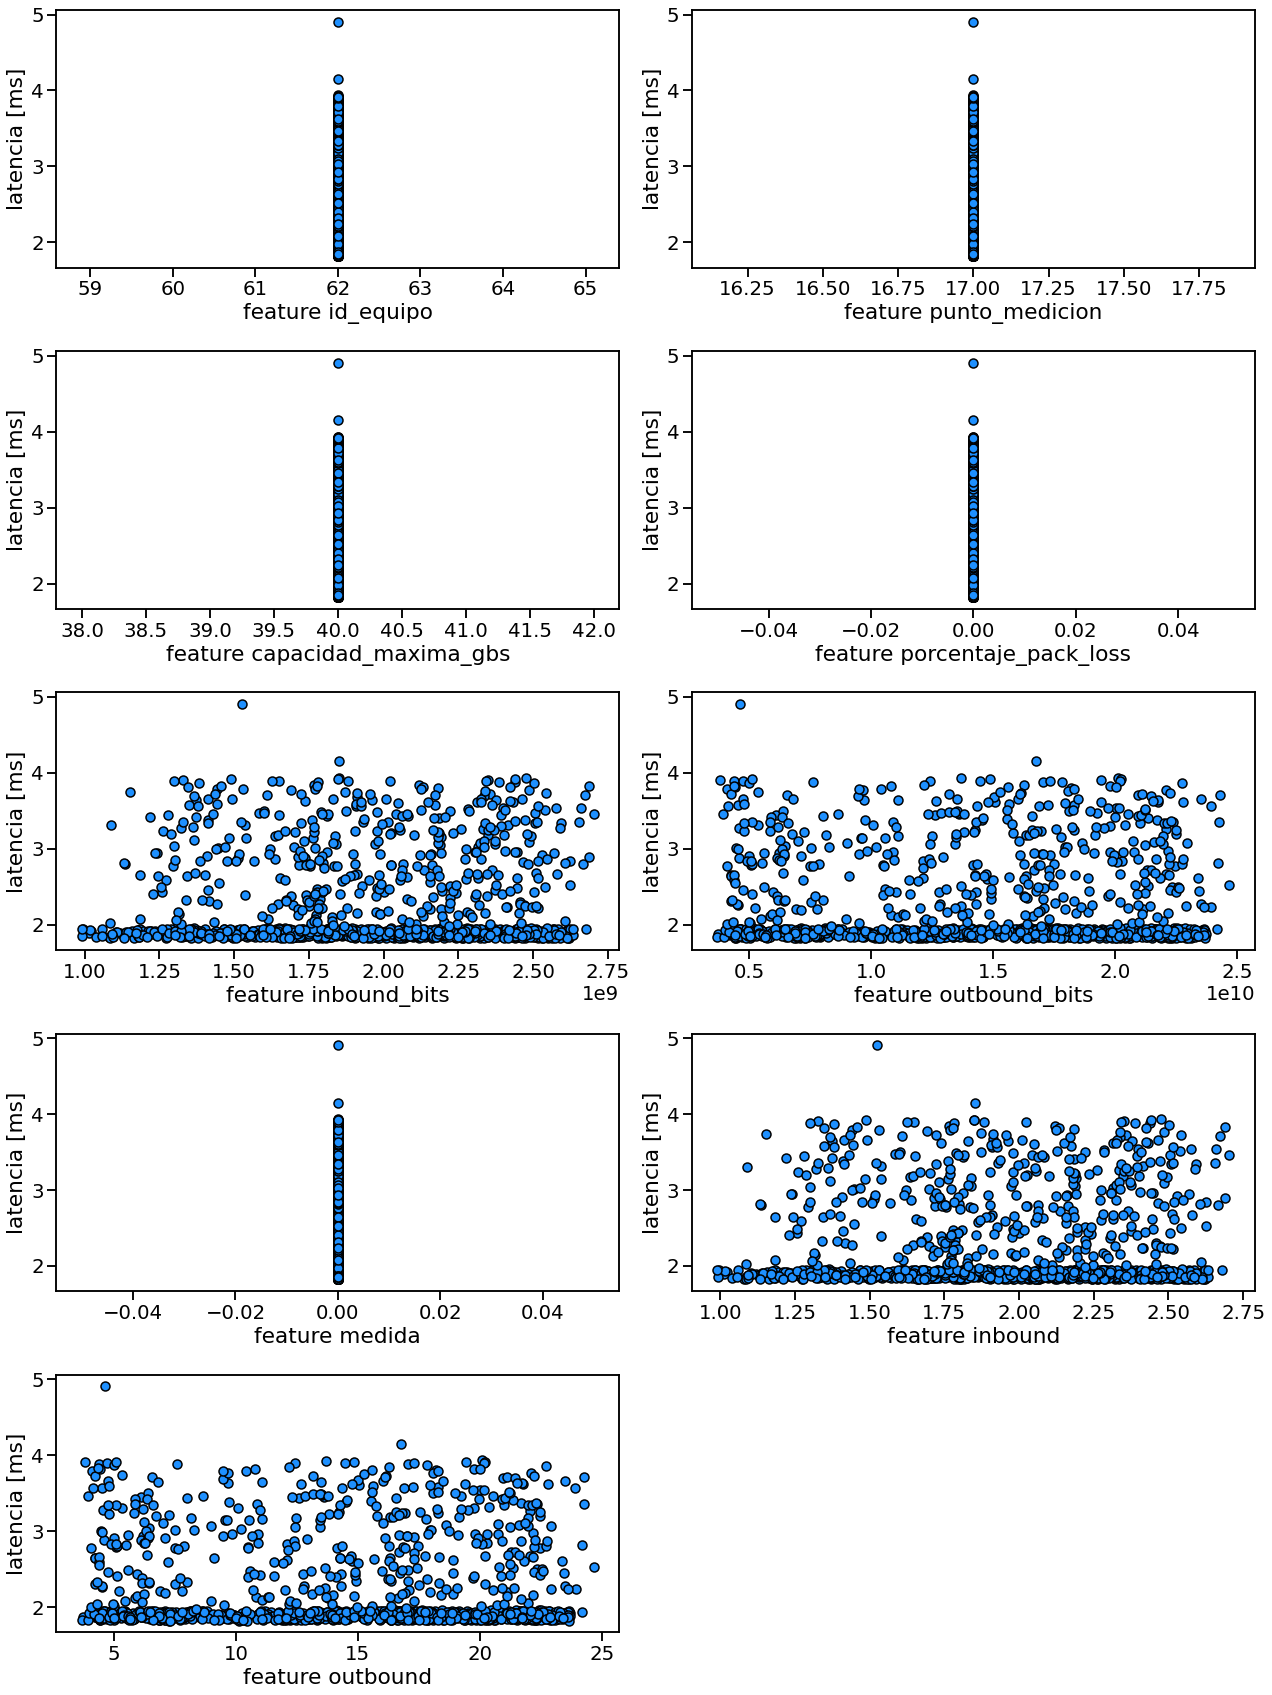

In [21]:
fig = plt.figure(figsize=(18, 24))

index = 0
for feature in X.columns:
    XX = X[[feature]]
    index += 1
    ax = plt.subplot(5, 2, index)
    ax.scatter(XX[:], y, facecolor="dodgerblue", edgecolor="k", label="datos")
    ax.set_xlabel(f'feature {feature}')
    ax.set_ylabel('latencia [ms]')
    # end for
fig.tight_layout()
plt.show()


**Nota**

A priori no podemos distinguir si hay relacion de la feature latencia_ms con las demás

### 1.2 **División de datos en conjuntos de entrenamiento y evaluación**

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (training) y evaluación (test).

Utilizar aproximadamente 70% de los datos para entrenamiento y 30% para validación.

Links:
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [22]:
random_state = np.random.RandomState(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.8, 
    random_state=random_state
    )

In [23]:
X_train.shape, X_test.shape

((1032, 9), (258, 9))

### 1.3 **Regresion Lineal**

Link:
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


#### 1.3.1 Seleccionamos un unico feature

Seleccionamos uno o más feature del dataset que no sea categórico, por ejemplo `INBOUND_BITS`

In [24]:
X_train_f = X_train[['inbound_bits']]
X_test_f = X_test[['inbound_bits']]
X_train_f.shape, X_test_f.shape

((1032, 1), (258, 1))

Instanciar y entrenar con regresion lineal 

In [25]:
linear = LinearRegression()
linear.fit(X_train_f, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Evaluar calculando el error cuadratico medio para los set de entrenamiento y testing

In [26]:
y_train_pred = linear.predict(X_train_f)
y_test_pred = linear.predict(X_test_f)

Evaluamos el desempeño del clasificador utilizando la media del error cuadrado (`MSE` o `Mean Squared Error`) sobre el conjunto de datos de entrenamiento `(X_train, y_train)` y lo comparamos con el de validación `(X_val, y_test)`.
Mientras más cercano a cero mejor

In [27]:
print(f"MSE para entrenamiento: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"MSE para validación   : {mean_squared_error(y_test, y_test_pred):.4f}")

MSE para entrenamiento: 0.3323
MSE para validación   : 0.4024


#### 1.3.1.1 **Visualizacion**

**Warning**: Tener en cuenta que si son dos o mas features no se va a poder visualizar

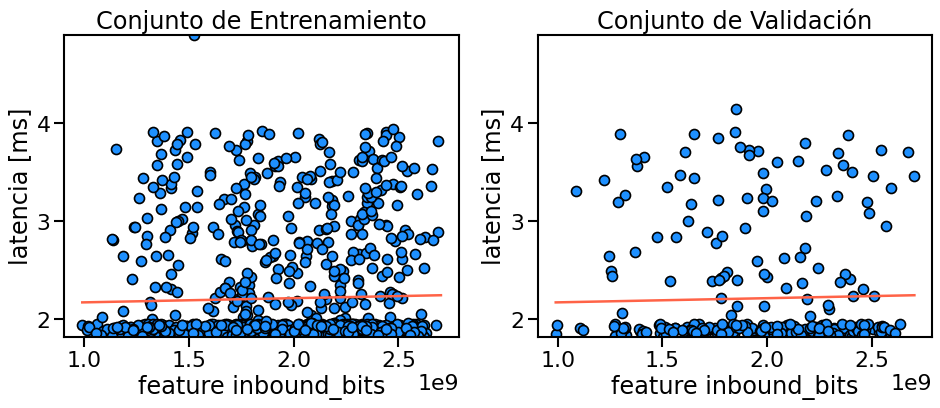

In [28]:
plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

X_range_start = np.min(np.r_[X_train_f, X_test_f])
X_range_stop = np.max(np.r_[X_train_f, X_test_f])
y_range_start = np.min(np.r_[y_train, y_test])
y_range_stop = np.max(np.r_[y_train, y_test])
X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)

# Conjunto de entrenamiento
ax = plt.subplot(1, 2, 1)
ax.scatter(X_train_f, y_train,
           facecolor="dodgerblue", edgecolor="k", label="datos")
ax.plot(X_linspace, linear.predict(X_linspace), color="tomato", label="modelo")
ax.set_ylim(y_range_start, y_range_stop)
ax.set_xlabel('feature inbound_bits')
ax.set_ylabel('latencia [ms]')
ax.set_title("Conjunto de Entrenamiento")

# Conjunto de validación
ax = plt.subplot(1, 2, 2)
ax.scatter(X_test_f, y_test, facecolor="dodgerblue", edgecolor="k", label="datos")
ax.plot(X_linspace, linear.predict(X_linspace), color="tomato", label="modelo")
ax.set_ylim(y_range_start, y_range_stop)
ax.set_title("Conjunto de Validación")
ax.set_xlabel('feature inbound_bits')
ax.set_ylabel('latencia [ms]')

plt.show()

#### 1.3.2 Seleccionamos todas las features

In [29]:
X_train.shape, X_test.shape

((1032, 9), (258, 9))

Instanciar y entrenar con regresion lineal 

In [30]:
linear_af = LinearRegression()
linear_af.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Evaluar calculando el error cuadratico medio para los set de entrenamiento y testing

In [31]:
y_train_pred_af = linear_af.predict(X_train)
y_test_pred_af = linear_af.predict(X_test)

print(f"MSE para entrenamiento: {mean_squared_error(y_train, y_train_pred_af):.4f}")
print(f"MSE para validación   : {mean_squared_error(y_test, y_test_pred_af):.4f}")

MSE para entrenamiento: 0.3314
MSE para validación   : 0.4046


##### Utilizando todas las features notamos una leve mejoría en las predicciones sobre le conjunto de *test*. Evaluando los resultados con el Error Cuadrático Medio

### 1.4 **EXTRA: Regresión Polinomial**

Link:
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

#### 1.4.1 Con una unica feature

In [32]:
train_errors = []
test_errors = []
degrees = range(1, 30)
min_mse = 50

for degree in degrees: 
       
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_f, y_train)
    
    y_train_pred = model.predict(X_train_f)
    y_test_pred = model.predict(X_test_f)
    
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    if (min_mse > test_error):
      min_mse = test_error
      min_degree = degree
    
print(f'Degree Minimo: {min_degree}' )
print(f'MSE Minimo: {min_mse:0.4}')

Degree Minimo: 29
MSE Minimo: 0.3928


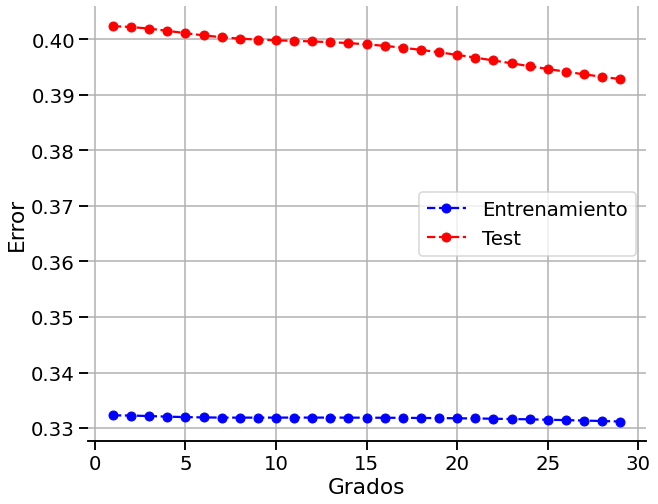

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(degrees, train_errors, color="blue", label="Entrenamiento", 
         marker='o', linestyle='--')
plt.plot(degrees, test_errors, color="red", label="Test", 
         marker='o', linestyle='--')
sns.despine(left=True)
plt.legend()
plt.xlabel("Grados")
plt.ylabel("Error")
plt.grid(True)
plt.show()

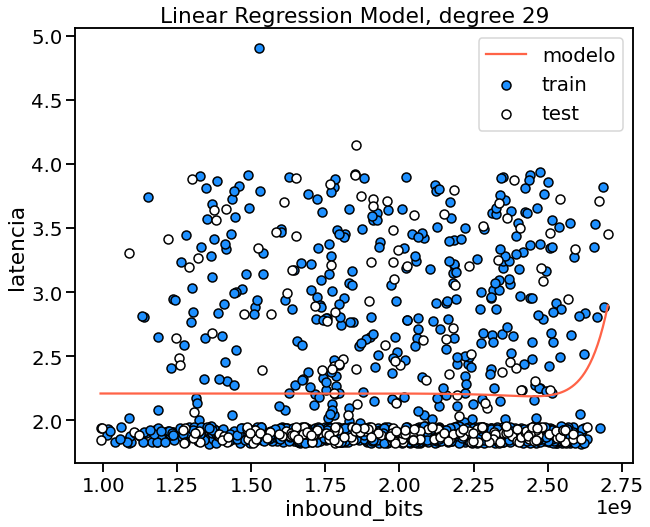

In [34]:
plt.figure(figsize=(10,8))
x_start = np.min(np.r_[X_train_f, X_test_f])
x_end = np.max(np.r_[X_train_f, X_test_f])

x = np.linspace(x_start, x_end, 200).reshape(-1, 1)
plt.plot(x, model.predict(x), color="tomato", label="modelo")

plt.scatter(X_train_f, y_train, facecolor="dodgerblue", edgecolor="k", 
            label="train")
plt.scatter(X_test_f, y_test, facecolor="white", edgecolor="k", label="test")

plt.xlabel('inbound_bits')
plt.ylabel('latencia')
plt.title(f'Linear Regression Model, degree {degree}')
plt.legend()
plt.show()

#### 1.4.1 Con todas las features

In [35]:
train_errors = []
test_errors = []
degrees = range(1, 10)
min_mse = 50

for degree in degrees: 
    
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    if (min_mse > test_error):
      min_mse = test_error
      min_degree = degree
    
print(f'Degree Minimo: {min_degree}' )
print(f'MSE Minimo: {min_mse:0.4}')

Degree Minimo: 9
MSE Minimo: 0.3892


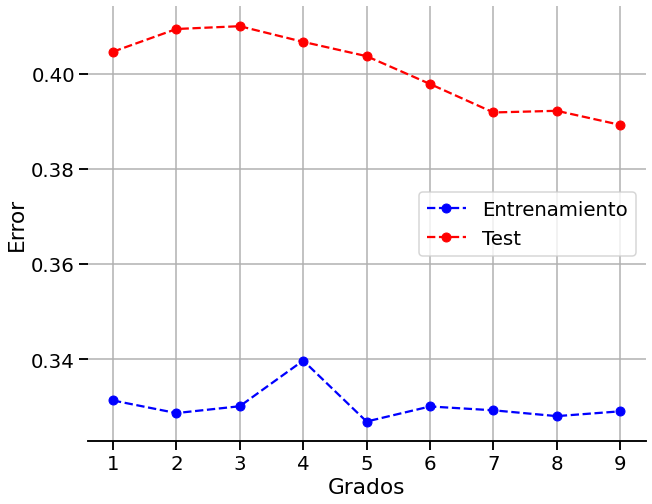

In [36]:
plt.figure(figsize=(10, 8))
plt.plot(degrees, train_errors, color="blue", label="Entrenamiento", 
         marker='o', linestyle='--')
plt.plot(degrees, test_errors, color="red", label="Test", 
         marker='o', linestyle='--')
sns.despine(left=True)
plt.legend()
plt.xlabel("Grados")
plt.ylabel("Error")
plt.grid(True)
plt.show()

**Nota:**

Podemos ver que al predecir con todas las features obtenemos un resultado mejor, basándonos en está última afirmación observamos que a partir del grado **7** (grados de libertad del polinomio) en el conjunto de test empieza a haber un **sobreajuste** sobre ambos conjuntos de datos.

## 2. **Clasificacion**
---

Elija algun `PUNTO MEDICION`, por ejemplo **ABA - Abasto Cliente**.

Vamos a predecir el `PORCENTAJE_PACK_LOSS` de dicho punto de medición.  
Como esta variable no es categorica, vamos a codificarla como tal (guiarse por lo que saben de **Analisis y Curacion de Datos**), para ello vamos a tomar los siguientes rangos:
* Si `PORCENTAJE_PACK_LOSS` $\in [0, 0.05) \Rightarrow$ 0
* Si `PORCENTAJE_PACK_LOSS` $\in [0.05, 0.1) \Rightarrow$ 1
* Si `PORCENTAJE_PACK_LOSS` $\in [0.1, \infty) \Rightarrow$ 2

### 2.1  Segmentamos la variable `PORCENTAJE_PACK_LOSS`

In [37]:
print(df['porcentaje_pack_loss'].min())
print(df['porcentaje_pack_loss'].max())

0.0
58.28972430108815


In [38]:
df_notna['ppl_segment'] = pd.cut(
    df_notna.porcentaje_pack_loss, [0,0.05,0.1,100], 
    right=False, labels=["0", "1", "2"]
    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


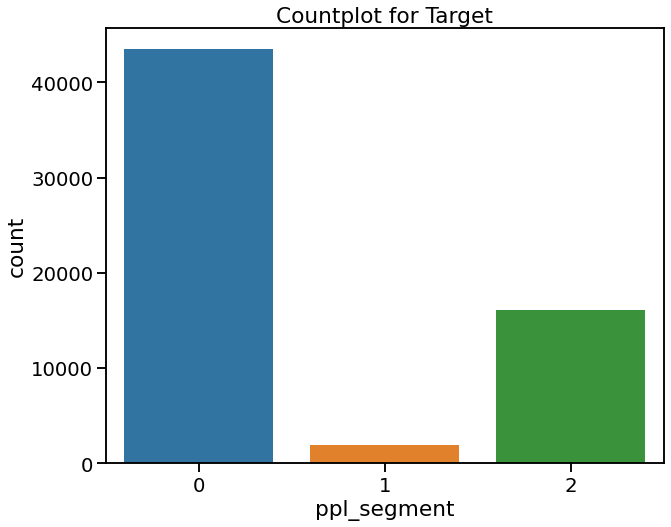

In [39]:
plt.figure(figsize=(10, 8))
sns.countplot(df_notna.ppl_segment)
plt.title('Countplot for Target')
plt.show()

### 2.2  Elejimos como `PUNTO_MEDICION` **NOC - ACHALA - Solo Dolores**.

In [40]:
df_noc_ac = df_notna[df_notna['punto_medicion'] == 23]
df_noc_ac

,id_equipo,punto_medicion,capacidad_maxima_gbs,fecha_inicio_medicion,fecha_hora,fecha_fin_medicion,paso,latencia_ms,porcentaje_pack_loss,inbound_bits,outbound_bits,medida,inbound,outbound,ppl_segment
7590,41,23,0.132121,2020-05-01 00:59:59.995,2020-05-01 03:00:00,2020-05-28 12:59:59.995,7200,0.743911,4.404621,8.062459e+06,7.078502e+07,1,8.062459,70.785021,2
7591,41,23,0.132121,2020-05-01 00:59:59.995,2020-05-01 05:00:00,2020-05-28 12:59:59.995,7200,0.763697,3.048282,4.143939e+06,2.454991e+07,1,4.143939,24.549911,2
7592,41,23,0.132121,2020-05-01 00:59:59.995,2020-05-01 07:00:00,2020-05-28 12:59:59.995,7200,0.769680,1.621055,1.719140e+06,1.706964e+07,1,1.719140,17.069642,2
7593,41,23,0.132121,2020-05-01 00:59:59.995,2020-05-01 09:00:00,2020-05-28 12:59:59.995,7200,0.745932,3.539826,2.286583e+06,2.999145e+07,1,2.286583,29.991453,2
7594,41,23,0.132121,2020-05-01 00:59:59.995,2020-05-01 11:00:00,2020-05-28 12:59:59.995,7200,0.756327,0.000000,5.810312e+06,5.609825e+07,1,5.810312,56.098246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51883,41,23,0.132121,2020-06-22 00:59:59.995,2020-07-26 17:00:00,2020-07-27 00:59:59.995,7200,0.751019,1.769656,7.698643e+06,8.795588e+07,1,7.698643,87.955876,2
51884,41,23,0.132121,2020-06-22 00:59:59.995,2020-07-26 19:00:00,2020-07-27 00:59:59.995,7200,0.750622,1.047301,7.853787e+06,8.892217e+07,1,7.853787,88.922170,2
51885,41,23,0.132121,2020-06-22 00:59:59.995,2020-07-26 21:00:00,2020-07-27 00:59:59.995,7200,0.752241,1.996285,1.097643e+07,1.175032e+08,1,10.976425,117.503208,2
51886,41,23,0.132121,2020-06-22 00:59:59.995,2020-07-26 23:00:00,2020-07-27 00:59:59.995,7200,0.728276,0.000000,1.177892e+07,1.183958e+08,1,11.778916,118.395821,0


### 2.3  Separamos el dataset `TARGET` del resto

In [41]:
# Separamos el "target" del resto del dataset
X = df_noc_ac.loc[:, df_notna.columns != 'ppl_segment']
y = df_noc_ac['ppl_segment']

In [42]:
X.shape, y.shape

((1290, 14), (1290,))

### 2.4  Seleccionamos uno o más feature del dataset que no sea categórico, por ejemplo `INBOUND_BITS` y `OUTBOUND_BITS`

In [49]:
cols = ['id_equipo', 'punto_medicion', 
        'capacidad_maxima_gbs', 'inbound_bits', 
        'outbound_bits'
        ]
X_clasif = X[cols]

**División de datos en conjuntos de entrenamiento y evaluación**

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (training) y evaluación (test).

Utilizar aproximadamente 70% de los datos para entrenamiento y 30% para validación.

Links:
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_clasif, y, train_size=0.8, random_state=0)

In [51]:
X_train.shape, X_test.shape

((1032, 5), (258, 5))

In [52]:
y_train.shape, y_test.shape

((1032,), (258,))

>### **Regresion Logistica**

Link:
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [53]:
# defino función para calcular los scores
def all_scores(y_train,y_test,y_train_pred,y_test_pred):
    sol=np.zeros((4,1))

    sol[0] = accuracy_score(y_train, y_train_pred)
    sol[1] = accuracy_score(y_test, y_test_pred)
    sol[2] = balanced_accuracy_score(y_train, y_train_pred)
    sol[3] = balanced_accuracy_score(y_test, y_test_pred)

    df = pd.DataFrame(
        sol, 
        index=['ACCURACY_TRAIN','ACCURACY_TEST',
               'BALANCE_ACC_TRAIN','BALANCE_ACC_TEST']
               )
    df.columns = ['Score']
    
    return df

In [54]:
# Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
penalty = 'l2' 

# 1/alpha Parámetro de regularización. También denominado como 
# parámetro `lambda`. Debe ser mayor que 0.
c_alpha = 1e+3 

random_state = np.random.RandomState(0)

model_default = make_pipeline(
    # StandardScaler(), 
    LogisticRegression(random_state=random_state)
    )

# model =  # parametros por defecto
model_default.fit(X_train, y_train)

y_train_pred = model_default.predict(X_train)
y_test_pred = model_default.predict(X_test)

y_train_pred_rl_def = y_train_pred
y_test_pred_rl_def = y_test_pred

df_rl_def = all_scores(y_train,y_test,y_train_pred,y_test_pred)
display(df_rl_def)

,Score
ACCURACY_TRAIN,0.894380
ACCURACY_TEST,0.891473
BALANCE_ACC_TRAIN,0.333333
BALANCE_ACC_TEST,0.500000


In [55]:
model1 = LogisticRegression(
    C=c_alpha, solver='lbfgs',
     penalty=penalty, 
     multi_class='ovr', 
     class_weight='balanced'
     )

model1.fit(X_train, y_train)

y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

y_train_pred_rl_hp1 = y_train_pred
y_test_pred_rl_hp1 = y_test_pred

df_rl_hp1 = all_scores(y_train,y_test,y_train_pred,y_test_pred)
display(df_rl_hp1)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


,Score
ACCURACY_TRAIN,0.307171
ACCURACY_TEST,0.317829
BALANCE_ACC_TRAIN,0.540113
BALANCE_ACC_TEST,0.397826


In [56]:
model2 = LogisticRegression(
    C=1e+3, solver='lbfgs', 
    penalty=penalty,
    multi_class='ovr'
    )
model2.fit(X_train, y_train)

y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

df_rl_hp2 = all_scores(y_train,y_test,y_train_pred,y_test_pred)
display(df_rl_hp2)


,Score
ACCURACY_TRAIN,0.894380
ACCURACY_TEST,0.891473
BALANCE_ACC_TRAIN,0.333333
BALANCE_ACC_TEST,0.500000


#### **Matriz de Confusion**

Plotear las matrices de confunsion y sacar conclusiones

### Dataset de Entrenamiento

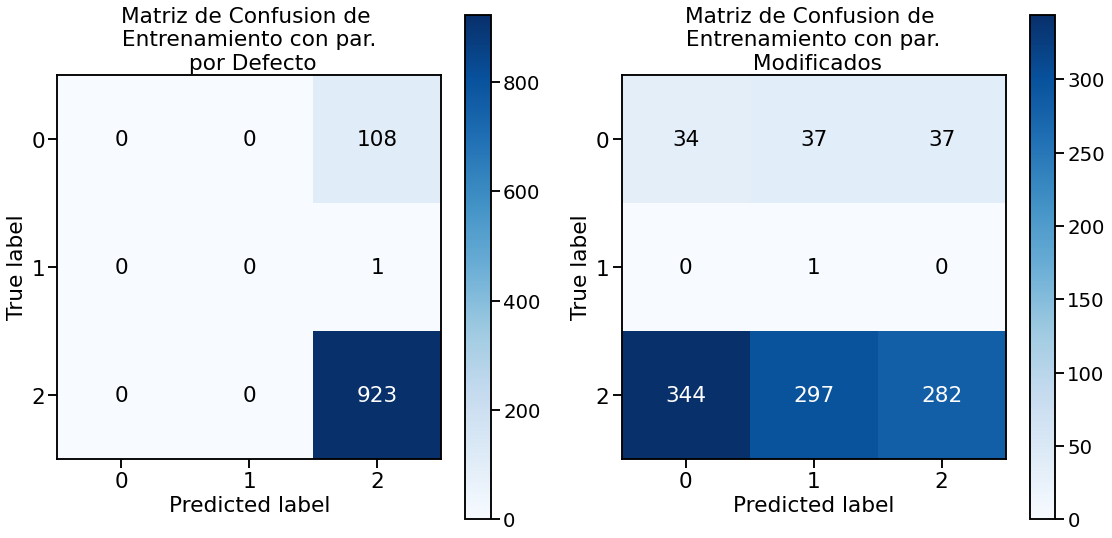

In [57]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot('121')

skplt.metrics.plot_confusion_matrix(
    y_train, 
    y_train_pred_rl_def,
    ax=ax1
    )
ax1.set_title('Matriz de Confusion de \n Entrenamiento con par. \n por Defecto')

ax2 = plt.subplot('122')
skplt.metrics.plot_confusion_matrix(
    y_train, 
    y_train_pred_rl_hp1,
    ax=ax2
    )
ax2.set_title('Matriz de Confusion de \n Entrenamiento con par. \n Modificados')
fig.tight_layout()
plt.show()

### Dataset de Test

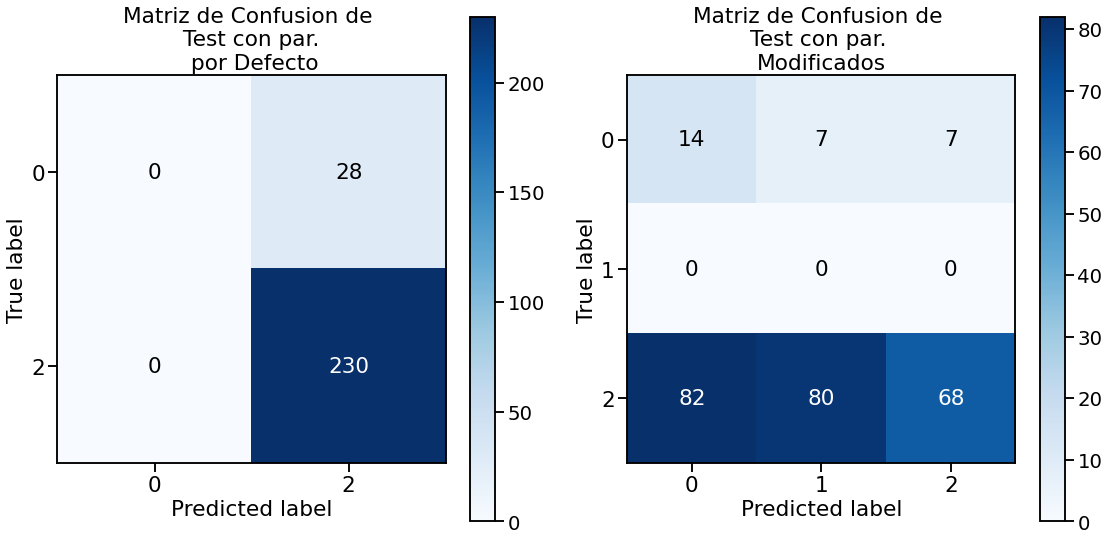

In [58]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot('121')

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_test_pred_rl_def,
    ax=ax1, 
    )

ax1.set_title('Matriz de Confusion de \n Test con par. \n por Defecto')
ax2 = plt.subplot('122')
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_test_pred_rl_hp1,
    ax=ax2
    )
ax2.set_title('Matriz de Confusion de \nTest con par. \nModificados')
fig.tight_layout()
plt.show()

## Conclusiones

In [61]:
# Ver otras formas de comparar de ver el porcentaje de acertividad del modelo
# En forecast no se hace shuffle

df = pd.concat([df_rl_def, df_rl_hp1, df_rl_hp2], axis=1)
#print(df)
df.columns = ['ScoreRLDefault', 'ScoreRLHP1', 'ScoreRLHP2']
# tabla comparando scores de SGD y DT con valores por omisión:
print('Tabla de scores:')
display(df)

Tabla de scores:


,ScoreRLDefault,ScoreRLHP1,ScoreRLHP2
ACCURACY_TRAIN,0.894380,0.307171,0.894380
ACCURACY_TEST,0.891473,0.317829,0.891473
BALANCE_ACC_TRAIN,0.333333,0.540113,0.333333
BALANCE_ACC_TEST,0.500000,0.397826,0.500000


Podemos verificar que el modelo con mayor acertividad es el que se aplica por defecto. Por lo tanto no hace falta modificar los Hiper Parametros para mejorarlo.